In [95]:
import os
import cv2
import numpy as np
import random

### 1. Оценим среднее значение пикселя на изображении (отдельно для спутниковых изображений, отдельно для карт)

In [97]:
maps_folder = 'dataset/map'
satellites_folder = 'dataset/satellite'

corners_folder = 'dataset/corners'

In [99]:
%%time
mean_maps = []
mean_satellites = []

for file in os.listdir(corners_folder):
    filename = file.split('.')[0] + '.png'
    img = cv2.imread(os.path.join(maps_folder, filename))
    # сначала получаем среднее значение для каждого пикселя, потом берём среднее по всем пикселям
    mean_maps.append(np.mean(np.mean(img, axis=2)))
    
    img_satellite = cv2.imread(os.path.join(satellites_folder, filename))
    mean_satellites.append(np.mean(np.mean(img_satellite, axis=2)))
    
mean_maps = np.array(mean_maps)
mean_satellites = np.array(mean_satellites)

print("Maps mean:", np.mean(mean_maps))
print("Satellites mean:", np.mean(mean_satellites))

Maps mean: 232.393494664
Satellites mean: 132.801123625
CPU times: user 3min 49s, sys: 5.61 s, total: 3min 55s
Wall time: 4min 25s


Здесь видно, что спутниковые изображения несколько более тёмные.

### 2. Случайным образом разобъём выборку на train, validate и test

In [100]:
filenames = list(map(lambda x: x.split('.')[0], os.listdir(corners_folder)))
random.shuffle(filenames)

In [101]:
train_part = 0.6
validate_part = 0.2
test_part = 0.2

files_count = len(filenames)
print(files_count)

train_count = int(files_count * train_part)
validate_count = int(files_count * validate_part) + 1
test_count = files_count - train_count - validate_count

print("train count: {}, validate count: {}, test count: {}".format(train_count, validate_count, test_count))

21849
train count: 13109, validate count: 4370, test count: 4370


In [102]:
train_filenames = filenames[:train_count]
validate_filenames = filenames[train_count:(train_count + validate_count)]
test_filenames = filenames[-test_count:]

In [103]:
print(len(train_filenames), len(validate_filenames), len(test_filenames))

13109 4370 4370


Тестовую выборку будем использовать для обучения модели. На валидейте будем оценивать модель в процессе обучения. Тестовую выборку будем использовать для сравнения нескольких моделей между собой.

### 3. Теперь проверим, что среднее значение одного пикселя статистически значимо получилось одинаковым в каждой из выборок

In [104]:
%%time
train_mean_maps = []
train_mean_satellites = []

validate_mean_maps = []
validate_mean_satellites = []

test_mean_maps = []
test_mean_satellites = []

for filename in train_filenames:
    img = cv2.imread(os.path.join(maps_folder, filename + '.png'))
    train_mean_maps.append(np.mean(np.mean(img, axis=2)))
    
    satellite_img = cv2.imread(os.path.join(satellites_folder, filename + '.png'))
    train_mean_satellites.append(np.mean(np.mean(satellite_img, axis=2)))
    
train_mean_maps = np.array(train_mean_maps)
train_mean_satellites = np.array(train_mean_satellites)

print(np.mean(train_mean_maps))
print(np.mean(train_mean_satellites))


for filename in validate_filenames:
    img = cv2.imread(os.path.join(maps_folder, filename + '.png'))
    validate_mean_maps.append(np.mean(np.mean(img, axis=2)))
    
    satellite_img = cv2.imread(os.path.join(satellites_folder, filename + '.png'))
    validate_mean_satellites.append(np.mean(np.mean(satellite_img, axis=2)))
    
validate_mean_maps = np.array(validate_mean_maps)
validate_mean_satellites = np.array(validate_mean_satellites)

print(np.mean(validate_mean_maps))
print(np.mean(validate_mean_satellites))


for filename in test_filenames:
    img = cv2.imread(os.path.join(maps_folder, filename + '.png'))
    test_mean_maps.append(np.mean(np.mean(img, axis=2)))
    
    satellite_img = cv2.imread(os.path.join(satellites_folder, filename + '.png'))
    test_mean_satellites.append(np.mean(np.mean(satellite_img, axis=2)))
    
test_mean_maps = np.array(test_mean_maps)
test_mean_satellites = np.array(test_mean_satellites)

print(np.mean(test_mean_maps))
print(np.mean(test_mean_satellites))


232.381053939
132.94021054
232.223273756
132.321353545
232.601034901
132.863664785
CPU times: user 3min 49s, sys: 5.55 s, total: 3min 54s
Wall time: 4min 33s


In [105]:
import matplotlib.pyplot as plt

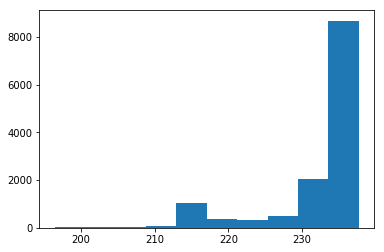

In [106]:
plt.hist(train_mean_maps)
plt.show()

Не похоже на нормальное распределение, значит критерии для нормального распределения использовать нельзя.

In [107]:
from scipy import stats

In [108]:
print(stats.mannwhitneyu(train_mean_maps, validate_mean_maps, alternative='two-sided'))
print(stats.mannwhitneyu(train_mean_maps, test_mean_maps, alternative='two-sided'))
print(stats.mannwhitneyu(validate_mean_maps, test_mean_maps, alternative='two-sided'))

MannwhitneyuResult(statistic=28695441.5, pvalue=0.85638480244821913)
MannwhitneyuResult(statistic=28135326.5, pvalue=0.078728112964812649)
MannwhitneyuResult(statistic=9362427.5, pvalue=0.11472057975470783)


Гипотезы о равенстве всех распределений на уровне значимости 0.05 отвергнуть не можем.

In [109]:
print(stats.mannwhitneyu(train_mean_satellites, validate_mean_satellites, alternative='two-sided'))
print(stats.mannwhitneyu(train_mean_satellites, test_mean_satellites, alternative='two-sided'))
print(stats.mannwhitneyu(validate_mean_satellites, test_mean_satellites, alternative='two-sided'))

MannwhitneyuResult(statistic=28834034.0, pvalue=0.5087809501553241)
MannwhitneyuResult(statistic=28705036.0, pvalue=0.83040703023502627)
MannwhitneyuResult(statistic=9504019.5, pvalue=0.70639055511996562)


И здесь аналогично.

### 4. Сохраним разбиения

In [110]:
import pickle

In [111]:
train_val_test = {
    'train': list(train_filenames),
    'validate': list(validate_filenames),
    'test': list(test_filenames)
}

In [112]:
with open('dataset/train_val_test_split.pickle', 'wb') as f:
    pickle.dump(train_val_test, f)

### 5. Проверим, что во всех выборках статистически значимо среднее количество встречаний одного типа объекта на изображении одинаково.

In [113]:
from collections import Counter

In [114]:
tags_folder = 'dataset/tags'

tag_names = ['wood', 'water', 'valley', 'peak', 'ridge']

In [115]:
%%time
train_tag_counts = {
    'wood':[],
    'water':[],
    'valley':[],
    'peak':[],
    'ridge':[]
}

for filename in train_filenames:
    with open(os.path.join(tags_folder, filename + '.pickle'), 'rb') as f:
        tags = pickle.load(f)
        c = Counter(tags)
        
        for tag in tag_names:
            if tag in c:
                train_tag_counts[tag].append(c[tag])
            else:
                train_tag_counts[tag].append(0)


CPU times: user 636 ms, sys: 416 ms, total: 1.05 s
Wall time: 3.11 s


In [116]:
%%time
validate_tag_counts = {
    'wood':[],
    'water':[],
    'valley':[],
    'peak':[],
    'ridge':[]
}

for filename in validate_filenames:
    with open(os.path.join(tags_folder, filename + '.pickle'), 'rb') as f:
        tags = pickle.load(f)
        c = Counter(tags)
        
        for tag in tag_names:
            if tag in c:
                validate_tag_counts[tag].append(c[tag])
            else:
                validate_tag_counts[tag].append(0)


CPU times: user 204 ms, sys: 144 ms, total: 348 ms
Wall time: 921 ms


In [117]:
%%time
test_tag_counts = {
    'wood':[],
    'water':[],
    'valley':[],
    'peak':[],
    'ridge':[]
}

for filename in test_filenames:
    with open(os.path.join(tags_folder, filename + '.pickle'), 'rb') as f:
        tags = pickle.load(f)
        c = Counter(tags)
        
        for tag in tag_names:
            if tag in c:
                test_tag_counts[tag].append(c[tag])
            else:
                test_tag_counts[tag].append(0)


CPU times: user 212 ms, sys: 132 ms, total: 344 ms
Wall time: 868 ms


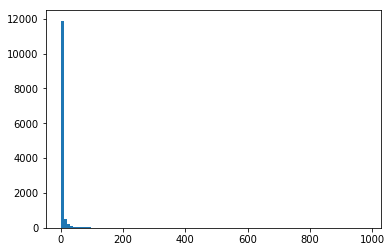

In [118]:
plt.hist(train_tag_counts['wood'], bins=100)
plt.show()

Тут тоже не похоже на нормальное распределение. Применим критерий Манна-Уитни.

In [119]:
print(stats.mannwhitneyu(train_tag_counts['water'], validate_tag_counts['water'], alternative='two-sided'))
print(stats.mannwhitneyu(train_tag_counts['water'], test_tag_counts['water'], alternative='two-sided'))
print(stats.mannwhitneyu(validate_tag_counts['water'], test_tag_counts['water'], alternative='two-sided'))

MannwhitneyuResult(statistic=28900497.0, pvalue=0.36037316023512023)
MannwhitneyuResult(statistic=28614372.5, pvalue=0.91851953310227663)
MannwhitneyuResult(statistic=9451077.0, pvalue=0.39660530405670902)


In [120]:
print(stats.mannwhitneyu(train_tag_counts['wood'], validate_tag_counts['wood'], alternative='two-sided'))
print(stats.mannwhitneyu(train_tag_counts['wood'], test_tag_counts['wood'], alternative='two-sided'))
print(stats.mannwhitneyu(validate_tag_counts['wood'], test_tag_counts['wood'], alternative='two-sided'))

MannwhitneyuResult(statistic=28924204.5, pvalue=0.25550881372139966)
MannwhitneyuResult(statistic=29194631.0, pvalue=0.025362560365901701)
MannwhitneyuResult(statistic=9639730.5, pvalue=0.36093230619930272)


Ну, равенство распределений train и validate отвергнуть не можем, а это самое главное (чтобы модель не переобучилась).

In [121]:
print(stats.mannwhitneyu(train_tag_counts['valley'], validate_tag_counts['valley'], alternative='two-sided'))
print(stats.mannwhitneyu(train_tag_counts['valley'], test_tag_counts['valley'], alternative='two-sided'))
print(stats.mannwhitneyu(validate_tag_counts['valley'], test_tag_counts['valley'], alternative='two-sided'))

MannwhitneyuResult(statistic=28736301.5, pvalue=0.39223611674344439)
MannwhitneyuResult(statistic=28701584.5, pvalue=0.59271585527078063)
MannwhitneyuResult(statistic=9536815.5, pvalue=0.78964601461307304)


In [122]:
print(stats.mannwhitneyu(train_tag_counts['peak'], validate_tag_counts['peak'], alternative='two-sided'))
print(stats.mannwhitneyu(train_tag_counts['peak'], test_tag_counts['peak'], alternative='two-sided'))
print(stats.mannwhitneyu(validate_tag_counts['peak'], test_tag_counts['peak'], alternative='two-sided'))

MannwhitneyuResult(statistic=28187753.5, pvalue=0.089667882639057533)
MannwhitneyuResult(statistic=28165580.0, pvalue=0.075195002781334494)
MannwhitneyuResult(statistic=9541466.5, pvalue=0.9494289714972125)


In [123]:
print(stats.mannwhitneyu(train_tag_counts['ridge'], validate_tag_counts['ridge'], alternative='two-sided'))
print(stats.mannwhitneyu(train_tag_counts['ridge'], test_tag_counts['ridge'], alternative='two-sided'))
print(stats.mannwhitneyu(validate_tag_counts['ridge'], test_tag_counts['ridge'], alternative='two-sided'))

MannwhitneyuResult(statistic=28515187.0, pvalue=0.3166003040051435)
MannwhitneyuResult(statistic=28460599.5, pvalue=0.15450808969274232)
MannwhitneyuResult(statistic=9530598.5, pvalue=0.73915605206344392)


В целом можно считать, что волне на таких данных можно обучаться.